In [1]:
from torchvision import transforms

transform  = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [2]:
from torchvision import models, datasets, transforms
from torchvision.models import ResNet50_Weights
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm   # For progress bar
from PIL import ImageFile

# allow partially read images instead of failing
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Define transforms and device
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# Prepare Model (remove final layer for features)
resnet = models.resnet50(weights=ResNet50_Weights.DEFAULT)
model = nn.Sequential(*(list(resnet.children())[:-1]))  # outputs [batch, 2048, 1, 1]
model.eval()
model.to(device)

def extract_features(batch_images):
    with torch.no_grad():
        batch_images = batch_images.to(device)
        feats = model(batch_images)                 # [batch, 2048, 1, 1]
        feats = feats.reshape(feats.size(0), -1)    # [batch, 2048]
        return feats.cpu().numpy()

dataset = datasets.ImageFolder("data/roads", transform=transform)
loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

train_features = []
train_labels = []

for imgs, labels in tqdm(loader, desc="Extracting features"):
    batch_feats = extract_features(imgs)
    train_features.append(batch_feats)
    train_labels.append(labels.numpy())

train_features = np.concatenate(train_features, axis=0)
train_labels = np.concatenate(train_labels, axis=0)

print("Feature vectors shape:", train_features.shape)
print("Labels shape:", train_labels.shape)

Using device: cuda


Extracting features: 100%|██████████| 146/146 [00:03<00:00, 37.39it/s]

Feature vectors shape: (4656, 2048)
Labels shape: (4656,)


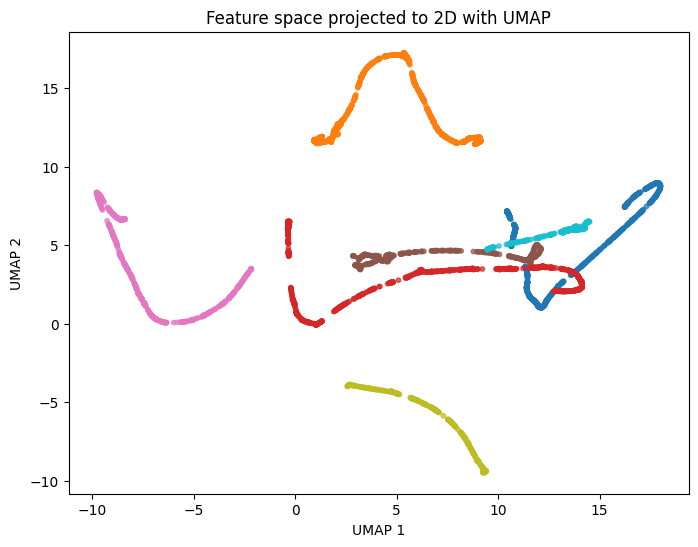

In [3]:
import matplotlib.pyplot as plt
import umap



reducer = umap.UMAP(n_components=6)
features_2D_UMAP = reducer.fit_transform(train_features)


plt.figure(figsize=(8,6))
plt.scatter(features_2D_UMAP[:,0], features_2D_UMAP[:,1], c=train_labels, cmap='tab10', s=10, alpha=0.7)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.title("Feature space projected to 2D with UMAP")
plt.show()

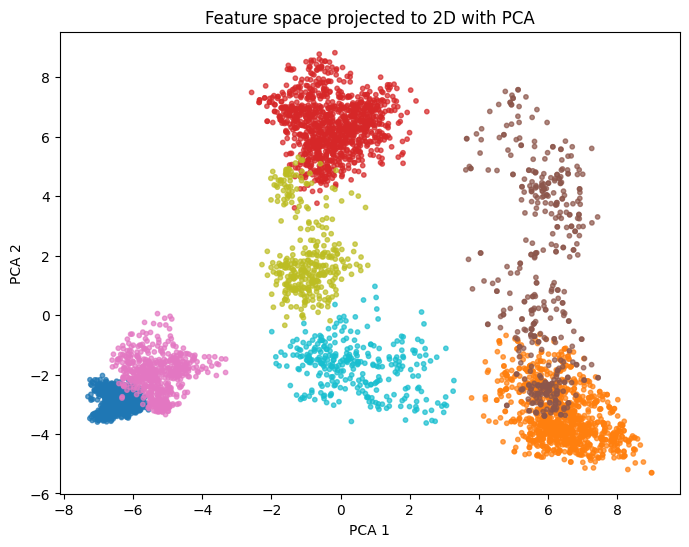

In [4]:
import sklearn.decomposition
from sklearn.decomposition import PCA


reducer = PCA(n_components=6)
features_2D_PCA = reducer.fit_transform(train_features)


plt.figure(figsize=(8,6))
plt.scatter(features_2D_PCA[:,0], features_2D_PCA[:,1], c=train_labels, cmap='tab10', s=10, alpha=0.7)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Feature space projected to 2D with PCA")
plt.show()



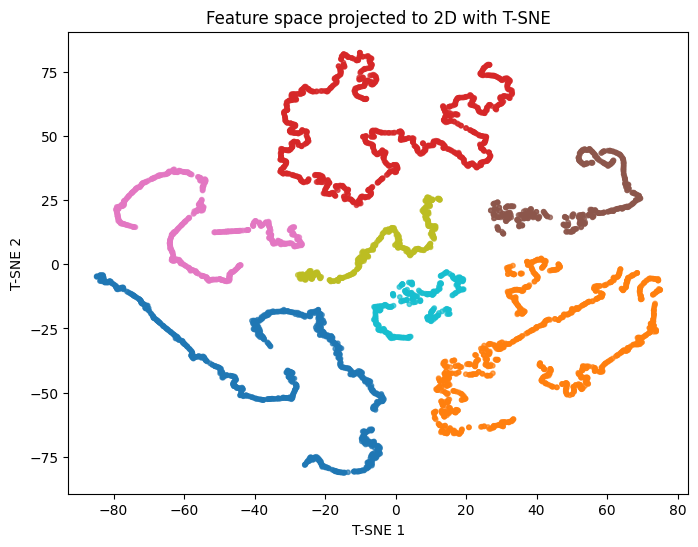

In [5]:
from sklearn.manifold import TSNE


reducer = TSNE(n_components=2, random_state=67)
features_2D_TSNE = reducer.fit_transform(train_features)


plt.figure(figsize=(8,6))
plt.scatter(features_2D_TSNE[:,0], features_2D_TSNE[:,1], c=train_labels, cmap='tab10', s=10, alpha=0.7)
plt.xlabel("T-SNE 1")
plt.ylabel("T-SNE 2")
plt.title("Feature space projected to 2D with T-SNE")
plt.show()

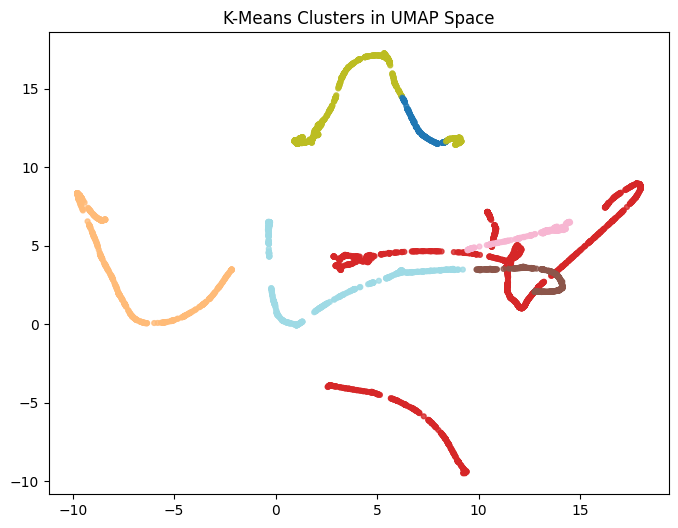

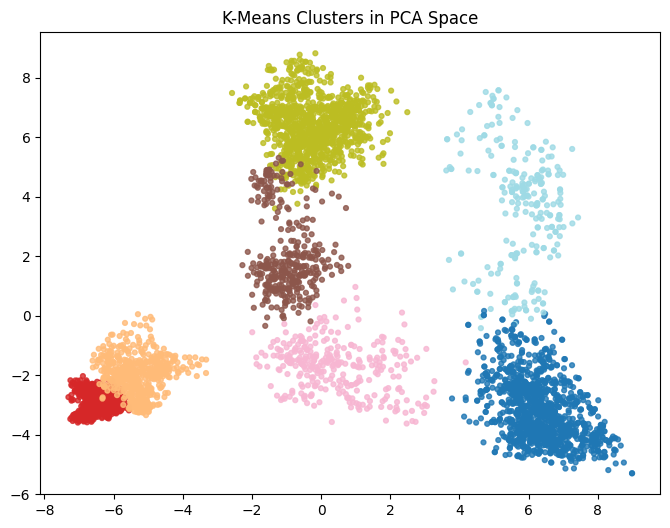

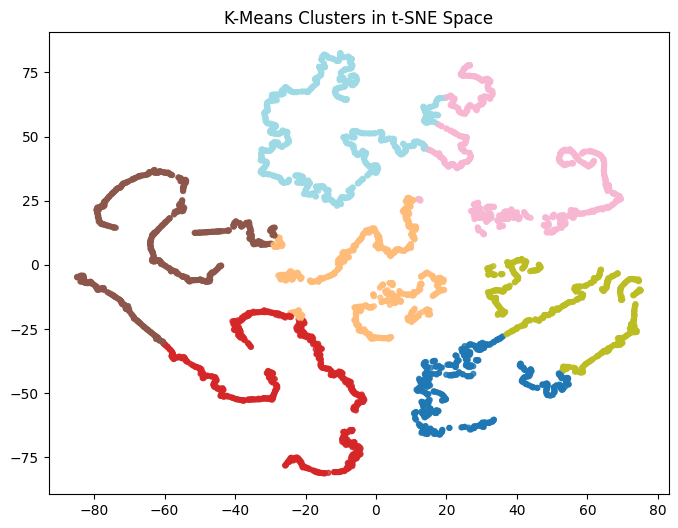

In [6]:
from sklearn.cluster import KMeans


#umap


n_clusters = len(np.unique(train_labels))  # or choose the “true” number or experiment with k
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(features_2D_UMAP)  # features_2D from UMAP/PCA/t-SNE

# Visualize clusters
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.scatter(features_2D_UMAP[:,0], features_2D_UMAP[:,1], c=cluster_labels, cmap='tab20', s=12, alpha=0.8)
plt.title('K-Means Clusters in UMAP Space')
plt.show()



# pca

n_clusters = len(np.unique(train_labels))  # or choose the “true” number or experiment with k
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(features_2D_PCA)  # features_2D from UMAP/PCA/t-SNE

# Visualize clusters
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.scatter(features_2D_PCA[:,0], features_2D_PCA[:,1], c=cluster_labels, cmap='tab20', s=12, alpha=0.8)
plt.title('K-Means Clusters in PCA Space')
plt.show()



# t-sne


n_clusters = len(np.unique(train_labels))  # or choose the “true” number or experiment with k
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(features_2D_TSNE)  # features_2D from UMAP/PCA/t-SNE

# Visualize clusters
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.scatter(features_2D_TSNE[:,0], features_2D_TSNE[:,1], c=cluster_labels, cmap='tab20', s=12, alpha=0.8)
plt.title('K-Means Clusters in t-SNE Space')
plt.show()









In [7]:
# get scores for each model



from sklearn.metrics import davies_bouldin_score, silhouette_score

db_score = davies_bouldin_score(features_2D_UMAP, cluster_labels)
sil_score = silhouette_score(features_2D_UMAP, cluster_labels)

print("UMAP Davies-Bouldin Index:", db_score)
print("UMAP Silhouette Score:", sil_score)


db_score = davies_bouldin_score(features_2D_PCA, cluster_labels)
sil_score = silhouette_score(features_2D_PCA, cluster_labels)

print("PCA Davies-Bouldin Index:", db_score)
print("PCA Silhouette Score:", sil_score)


db_score = davies_bouldin_score(features_2D_TSNE, cluster_labels)
sil_score = silhouette_score(features_2D_TSNE, cluster_labels)

print("TSNE Davies-Bouldin Index:", db_score)
print("TSNE Silhouette Score:", sil_score)




UMAP Davies-Bouldin Index: 1.7181340336317201
UMAP Silhouette Score: 0.2670671045780182
PCA Davies-Bouldin Index: 1.1727560053722577
PCA Silhouette Score: 0.3593479096889496
TSNE Davies-Bouldin Index: 0.7989065868928146
TSNE Silhouette Score: 0.39433249831199646
TSNE Davies-Bouldin Index: 0.7989065868928146
TSNE Silhouette Score: 0.39433249831199646


## Classification Models for Roads Dataset

In this section, we build and evaluate multiple classifiers for the roads dataset with **randomized train-test splitting** to avoid sequential bias in the image data.


In [8]:
# Step 1: Import necessary libraries for classification
import random
import os
from sklearn.model_selection import train_test_split, StratifiedKFold, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, 
    classification_report, 
    confusion_matrix,
    precision_recall_fscore_support,
    roc_curve, 
    auc,
    roc_auc_score
)
from sklearn.preprocessing import label_binarize
import joblib
import pandas as pd

print("="*80)
print("IMPORTING LIBRARIES FOR ROADS DATASET CLASSIFICATION")
print("="*80)
print("\n✓ Successfully imported:")
print("  - Scikit-learn classifiers (LogisticRegression, KNN, SVM, DecisionTree, RandomForest)")
print("  - Model evaluation metrics (accuracy, precision, recall, F1, ROC-AUC)")
print("  - Cross-validation tools (StratifiedKFold, learning curves)")
print("  - Data preprocessing (StandardScaler, train_test_split)")
print("\nThese tools will be used to build, evaluate, and analyze our classifiers.")


IMPORTING LIBRARIES FOR ROADS DATASET CLASSIFICATION

✓ Successfully imported:
  - Scikit-learn classifiers (LogisticRegression, KNN, SVM, DecisionTree, RandomForest)
  - Model evaluation metrics (accuracy, precision, recall, F1, ROC-AUC)
  - Cross-validation tools (StratifiedKFold, learning curves)
  - Data preprocessing (StandardScaler, train_test_split)

These tools will be used to build, evaluate, and analyze our classifiers.


In [9]:
# Step 2: Analyze dataset distribution BEFORE splitting
print("\n" + "="*80)
print("STEP 1: ANALYZING ROADS DATASET STRUCTURE")
print("="*80)

# Get unique classes
unique_labels = np.unique(train_labels)
road_classes = dataset.classes

print(f"\n📊 Dataset Information:")
print(f"  • Total number of samples: {len(train_labels)}")
print(f"  • Number of classes: {len(unique_labels)}")
print(f"  • Feature dimension (ResNet50 features): {train_features.shape[1]}")

print(f"\n🛣️ Road Classes in Dataset:")
for i, class_name in enumerate(road_classes):
    count = np.sum(train_labels == i)
    percentage = (count / len(train_labels)) * 100
    print(f"   {i+1}. {class_name}: {count} samples ({percentage:.1f}%)")

print(f"\n⚠️ Important Note: Images are loaded sequentially from disk.")
print(f"   We MUST use random shuffling to avoid sequential bias in our train/test split.")
print(f"   Sequential data can cause overfitting if train and test sets are adjacent.")



STEP 1: ANALYZING ROADS DATASET STRUCTURE

📊 Dataset Information:
  • Total number of samples: 4656
  • Number of classes: 7
  • Feature dimension (ResNet50 features): 2048

🛣️ Road Classes in Dataset:
   1. Daylight: 903 samples (19.4%)
   2. Night: 1050 samples (22.6%)
   3. RainyDay: 1049 samples (22.5%)
   4. RainyNight: 431 samples (9.3%)
   5. Snowy: 569 samples (12.2%)
   6. SunStroke: 347 samples (7.5%)
   7. Tunnel: 307 samples (6.6%)

⚠️ Important Note: Images are loaded sequentially from disk.
   We MUST use random shuffling to avoid sequential bias in our train/test split.
   Sequential data can cause overfitting if train and test sets are adjacent.


In [10]:
# Step 3: Perform RANDOMIZED train-test split using StratifiedShuffleSplit
# This ensures random sampling while maintaining class distribution
from sklearn.model_selection import StratifiedShuffleSplit

print("\n" + "="*80)
print("STEP 2: RANDOMIZED TRAIN-TEST SPLIT")
print("="*80)

# Use StratifiedShuffleSplit for random shuffling while preserving class ratios
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=67)

print(f"\n🔀 Splitting Strategy:")
print(f"   • Method: StratifiedShuffleSplit (shuffles data randomly)")
print(f"   • Test size: 20% of data")
print(f"   • Training size: 80% of data")
print(f"   • Random seed: 67 (for reproducibility)")
print(f"   • Class distribution: Preserved in both train and test sets")

# Perform the split
for train_idx, test_idx in sss.split(train_features, train_labels):
    x_train_raw, x_test_raw = train_features[train_idx], train_features[test_idx]
    y_train_raw, y_test_raw = train_labels[train_idx], train_labels[test_idx]

print(f"\n✓ Split Complete!")
print(f"\n📈 Training Set Statistics:")
print(f"   • Size: {x_train_raw.shape[0]} samples")
print(f"   • Features per sample: {x_train_raw.shape[1]}")

print(f"\n📊 Test Set Statistics:")
print(f"   • Size: {x_test_raw.shape[0]} samples")
print(f"   • Features per sample: {x_test_raw.shape[1]}")

# Verify class distribution
print(f"\n🎯 Class Distribution After Split:")
print(f"\n{'Class':<20} {'Train Count':<15} {'Train %':<15} {'Test Count':<15} {'Test %':<15}")
print("-" * 80)
for i, class_name in enumerate(road_classes):
    train_count = np.sum(y_train_raw == i)
    test_count = np.sum(y_test_raw == i)
    train_pct = (train_count / len(y_train_raw)) * 100
    test_pct = (test_count / len(y_test_raw)) * 100
    print(f"{class_name:<20} {train_count:<15} {train_pct:<15.1f} {test_count:<15} {test_pct:<15.1f}")

print(f"\n✓ Class ratios are balanced! Good stratification achieved.")


STEP 2: RANDOMIZED TRAIN-TEST SPLIT

🔀 Splitting Strategy:
   • Method: StratifiedShuffleSplit (shuffles data randomly)
   • Test size: 20% of data
   • Training size: 80% of data
   • Random seed: 67 (for reproducibility)
   • Class distribution: Preserved in both train and test sets

✓ Split Complete!

📈 Training Set Statistics:
   • Size: 3724 samples
   • Features per sample: 2048

📊 Test Set Statistics:
   • Size: 932 samples
   • Features per sample: 2048

🎯 Class Distribution After Split:

Class                Train Count     Train %         Test Count      Test %         
--------------------------------------------------------------------------------
Daylight             722             19.4            181             19.4           
Night                840             22.6            210             22.5           
RainyDay             839             22.5            210             22.5           
RainyNight           345             9.3             86              9.2    

In [11]:
# Step 4: Define multiple classifier pipelines
print("\n" + "="*80)
print("STEP 3: DEFINING CLASSIFIER PIPELINES")
print("="*80)

print(f"\n🤖 Building multiple classifier models with preprocessing:")
print(f"\n1. LOGISTIC REGRESSION")
print(f"   • Regularization: L2 (Ridge)")
print(f"   • Max iterations: 2000")
print(f"   • Scaling: StandardScaler (normalizes feature magnitudes)")

print(f"\n2. K-NEAREST NEIGHBORS (k=5)")
print(f"   • Neighbors: 5")
print(f"   • Distance metric: Euclidean")
print(f"   • Scaling: StandardScaler (important for distance-based methods)")

print(f"\n3. SUPPORT VECTOR MACHINE (Linear Kernel)")
print(f"   • Kernel: Linear (fast, interpretable)")
print(f"   • Regularization parameter: C=1.0")
print(f"   • Scaling: StandardScaler (critical for SVM)")

print(f"\n4. DECISION TREE")
print(f"   • Max depth: 20 (prevents overfitting)")
print(f"   • Splitting criterion: Gini impurity")
print(f"   • No scaling needed (tree-based model)")

print(f"\n5. RANDOM FOREST")
print(f"   • Trees: 100")
print(f"   • Max depth: 20")
print(f"   • Ensemble method (reduces overfitting)")
print(f"   • No scaling needed")

classifiers = {
    'Logistic Regression': make_pipeline(StandardScaler(), LogisticRegression(max_iter=2000, solver="lbfgs", random_state=67, n_jobs=-1)),
    'KNN (k=5)': make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=5, n_jobs=-1)),
    'SVM (Linear)': make_pipeline(StandardScaler(), SVC(kernel='linear', probability=True, random_state=67)),
    'Decision Tree': DecisionTreeClassifier(random_state=67, max_depth=20),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=20, random_state=67, n_jobs=-1),
}

print(f"\n✓ All {len(classifiers)} pipelines created successfully!")



STEP 3: DEFINING CLASSIFIER PIPELINES

🤖 Building multiple classifier models with preprocessing:

1. LOGISTIC REGRESSION
   • Regularization: L2 (Ridge)
   • Max iterations: 2000
   • Scaling: StandardScaler (normalizes feature magnitudes)

2. K-NEAREST NEIGHBORS (k=5)
   • Neighbors: 5
   • Distance metric: Euclidean
   • Scaling: StandardScaler (important for distance-based methods)

3. SUPPORT VECTOR MACHINE (Linear Kernel)
   • Kernel: Linear (fast, interpretable)
   • Regularization parameter: C=1.0
   • Scaling: StandardScaler (critical for SVM)

4. DECISION TREE
   • Max depth: 20 (prevents overfitting)
   • Splitting criterion: Gini impurity
   • No scaling needed (tree-based model)

5. RANDOM FOREST
   • Trees: 100
   • Max depth: 20
   • Ensemble method (reduces overfitting)
   • No scaling needed

✓ All 5 pipelines created successfully!


In [12]:
# Step 5: Train and evaluate all classifiers with cross-validation
print("\n" + "="*80)
print("STEP 4: TRAINING CLASSIFIERS WITH 5-FOLD CROSS-VALIDATION")
print("="*80)

print(f"\n📋 Evaluation Strategy:")
print(f"   • Cross-validation: 5-Fold StratifiedKFold")
print(f"   • Why 5-fold? Balances computation time and reliability")
print(f"   • Stratification: Maintains class ratios in each fold")
print(f"   • Metric: Accuracy (also tracking other metrics)")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=67)

results = {}
print(f"\n" + "="*80)

for clf_name, clf in tqdm(classifiers.items(), desc="Training classifiers", total=len(classifiers)):
    print(f"\n🔧 Training: {clf_name}")
    print("-" * 80)
    
    fold_accuracies = []
    fold_precisions = []
    fold_recalls = []
    fold_f1s = []
    
    # Perform cross-validation
    fold_num = 0
    for train_idx, val_idx in cv.split(x_train_raw, y_train_raw):
        fold_num += 1
        x_fold_train, x_fold_val = x_train_raw[train_idx], x_train_raw[val_idx]
        y_fold_train, y_fold_val = y_train_raw[train_idx], y_train_raw[val_idx]
        
        # Train classifier
        clf.fit(x_fold_train, y_fold_train)
        
        # Evaluate on validation fold
        y_fold_pred = clf.predict(x_fold_val)
        fold_acc = accuracy_score(y_fold_val, y_fold_pred)
        fold_prec = precision_recall_fscore_support(y_fold_val, y_fold_pred, average='macro')[0]
        fold_rec = precision_recall_fscore_support(y_fold_val, y_fold_pred, average='macro')[1]
        fold_f1 = precision_recall_fscore_support(y_fold_val, y_fold_pred, average='macro')[2]
        
        fold_accuracies.append(fold_acc)
        fold_precisions.append(fold_prec)
        fold_recalls.append(fold_rec)
        fold_f1s.append(fold_f1)
        
        print(f"   Fold {fold_num}: Acc={fold_acc:.4f} | Prec={fold_prec:.4f} | Rec={fold_rec:.4f} | F1={fold_f1:.4f}")
    
    # Calculate statistics
    mean_acc = np.mean(fold_accuracies)
    std_acc = np.std(fold_accuracies)
    mean_prec = np.mean(fold_precisions)
    mean_rec = np.mean(fold_recalls)
    mean_f1 = np.mean(fold_f1s)
    
    results[clf_name] = {
        'model': clf,
        'cv_accuracy': mean_acc,
        'cv_std': std_acc,
        'fold_accuracies': fold_accuracies,
        'cv_precision': mean_prec,
        'cv_recall': mean_rec,
        'cv_f1': mean_f1,
    }
    
    print(f"   ━━━ SUMMARY ━━━")
    print(f"   Mean Accuracy:  {mean_acc:.4f} ± {std_acc:.4f}")
    print(f"   Mean Precision: {mean_prec:.4f}")
    print(f"   Mean Recall:    {mean_rec:.4f}")
    print(f"   Mean F1-Score:  {mean_f1:.4f}")

print(f"\n" + "="*80)
print("✓ Cross-validation complete for all classifiers!")



STEP 4: TRAINING CLASSIFIERS WITH 5-FOLD CROSS-VALIDATION

📋 Evaluation Strategy:
   • Cross-validation: 5-Fold StratifiedKFold
   • Why 5-fold? Balances computation time and reliability
   • Stratification: Maintains class ratios in each fold
   • Metric: Accuracy (also tracking other metrics)



Training classifiers:   0%|          | 0/5 [00:00<?, ?it/s]


🔧 Training: Logistic Regression
--------------------------------------------------------------------------------
   Fold 1: Acc=1.0000 | Prec=1.0000 | Rec=1.0000 | F1=1.0000
   Fold 1: Acc=1.0000 | Prec=1.0000 | Rec=1.0000 | F1=1.0000
   Fold 2: Acc=1.0000 | Prec=1.0000 | Rec=1.0000 | F1=1.0000
   Fold 2: Acc=1.0000 | Prec=1.0000 | Rec=1.0000 | F1=1.0000
   Fold 3: Acc=1.0000 | Prec=1.0000 | Rec=1.0000 | F1=1.0000
   Fold 3: Acc=1.0000 | Prec=1.0000 | Rec=1.0000 | F1=1.0000
   Fold 4: Acc=1.0000 | Prec=1.0000 | Rec=1.0000 | F1=1.0000
   Fold 4: Acc=1.0000 | Prec=1.0000 | Rec=1.0000 | F1=1.0000


Training classifiers:  20%|██        | 1/5 [00:09<00:37,  9.32s/it]

   Fold 5: Acc=1.0000 | Prec=1.0000 | Rec=1.0000 | F1=1.0000
   ━━━ SUMMARY ━━━
   Mean Accuracy:  1.0000 ± 0.0000
   Mean Precision: 1.0000
   Mean Recall:    1.0000
   Mean F1-Score:  1.0000

🔧 Training: KNN (k=5)
--------------------------------------------------------------------------------
   Fold 1: Acc=1.0000 | Prec=1.0000 | Rec=1.0000 | F1=1.0000
   Fold 2: Acc=0.9987 | Prec=0.9992 | Rec=0.9971 | F1=0.9981
   Fold 3: Acc=1.0000 | Prec=1.0000 | Rec=1.0000 | F1=1.0000
   Fold 2: Acc=0.9987 | Prec=0.9992 | Rec=0.9971 | F1=0.9981
   Fold 3: Acc=1.0000 | Prec=1.0000 | Rec=1.0000 | F1=1.0000


Training classifiers:  40%|████      | 2/5 [00:10<00:12,  4.28s/it]

   Fold 4: Acc=1.0000 | Prec=1.0000 | Rec=1.0000 | F1=1.0000
   Fold 5: Acc=0.9987 | Prec=0.9992 | Rec=0.9971 | F1=0.9981
   ━━━ SUMMARY ━━━
   Mean Accuracy:  0.9995 ± 0.0007
   Mean Precision: 0.9997
   Mean Recall:    0.9988
   Mean F1-Score:  0.9992

🔧 Training: SVM (Linear)
--------------------------------------------------------------------------------
   Fold 1: Acc=1.0000 | Prec=1.0000 | Rec=1.0000 | F1=1.0000
   Fold 1: Acc=1.0000 | Prec=1.0000 | Rec=1.0000 | F1=1.0000
   Fold 2: Acc=1.0000 | Prec=1.0000 | Rec=1.0000 | F1=1.0000
   Fold 2: Acc=1.0000 | Prec=1.0000 | Rec=1.0000 | F1=1.0000
   Fold 3: Acc=1.0000 | Prec=1.0000 | Rec=1.0000 | F1=1.0000
   Fold 3: Acc=1.0000 | Prec=1.0000 | Rec=1.0000 | F1=1.0000
   Fold 4: Acc=1.0000 | Prec=1.0000 | Rec=1.0000 | F1=1.0000
   Fold 4: Acc=1.0000 | Prec=1.0000 | Rec=1.0000 | F1=1.0000


Training classifiers:  60%|██████    | 3/5 [00:26<00:19,  9.74s/it]

   Fold 5: Acc=1.0000 | Prec=1.0000 | Rec=1.0000 | F1=1.0000
   ━━━ SUMMARY ━━━
   Mean Accuracy:  1.0000 ± 0.0000
   Mean Precision: 1.0000
   Mean Recall:    1.0000
   Mean F1-Score:  1.0000

🔧 Training: Decision Tree
--------------------------------------------------------------------------------
   Fold 1: Acc=0.9919 | Prec=0.9913 | Rec=0.9900 | F1=0.9905
   Fold 1: Acc=0.9919 | Prec=0.9913 | Rec=0.9900 | F1=0.9905
   Fold 2: Acc=0.9960 | Prec=0.9958 | Rec=0.9974 | F1=0.9966
   Fold 2: Acc=0.9960 | Prec=0.9958 | Rec=0.9974 | F1=0.9966
   Fold 3: Acc=0.9933 | Prec=0.9925 | Rec=0.9908 | F1=0.9916
   Fold 3: Acc=0.9933 | Prec=0.9925 | Rec=0.9908 | F1=0.9916
   Fold 4: Acc=0.9919 | Prec=0.9941 | Rec=0.9877 | F1=0.9908
   Fold 4: Acc=0.9919 | Prec=0.9941 | Rec=0.9877 | F1=0.9908


Training classifiers:  80%|████████  | 4/5 [00:34<00:09,  9.13s/it]

   Fold 5: Acc=0.9839 | Prec=0.9835 | Rec=0.9828 | F1=0.9828
   ━━━ SUMMARY ━━━
   Mean Accuracy:  0.9914 ± 0.0040
   Mean Precision: 0.9914
   Mean Recall:    0.9897
   Mean F1-Score:  0.9905

🔧 Training: Random Forest
--------------------------------------------------------------------------------
   Fold 1: Acc=1.0000 | Prec=1.0000 | Rec=1.0000 | F1=1.0000
   Fold 1: Acc=1.0000 | Prec=1.0000 | Rec=1.0000 | F1=1.0000
   Fold 2: Acc=1.0000 | Prec=1.0000 | Rec=1.0000 | F1=1.0000
   Fold 2: Acc=1.0000 | Prec=1.0000 | Rec=1.0000 | F1=1.0000
   Fold 3: Acc=1.0000 | Prec=1.0000 | Rec=1.0000 | F1=1.0000
   Fold 3: Acc=1.0000 | Prec=1.0000 | Rec=1.0000 | F1=1.0000
   Fold 4: Acc=1.0000 | Prec=1.0000 | Rec=1.0000 | F1=1.0000
   Fold 4: Acc=1.0000 | Prec=1.0000 | Rec=1.0000 | F1=1.0000


Training classifiers: 100%|██████████| 5/5 [00:36<00:00,  7.25s/it]

   Fold 5: Acc=1.0000 | Prec=1.0000 | Rec=1.0000 | F1=1.0000
   ━━━ SUMMARY ━━━
   Mean Accuracy:  1.0000 ± 0.0000
   Mean Precision: 1.0000
   Mean Recall:    1.0000
   Mean F1-Score:  1.0000

✓ Cross-validation complete for all classifiers!


In [13]:
# Step 6: Identify best classifier and retrain on full training set
print("\n" + "="*80)
print("STEP 5: SELECTING BEST CLASSIFIER")
print("="*80)

# Find best based on CV accuracy
best_clf_name = max(results.keys(), key=lambda x: results[x]['cv_accuracy'])
best_result = results[best_clf_name]

print(f"\n🏆 BEST CLASSIFIER: {best_clf_name}")
print(f"   • Cross-validation Accuracy: {best_result['cv_accuracy']:.4f} ± {best_result['cv_std']:.4f}")
print(f"   • Mean Precision: {best_result['cv_precision']:.4f}")
print(f"   • Mean Recall: {best_result['cv_recall']:.4f}")
print(f"   • Mean F1-Score: {best_result['cv_f1']:.4f}")

print(f"\n📊 Retraining best classifier on FULL training set...")
print(f"   • Training samples: {len(x_train_raw)}")

# Retrain on full training set
best_clf = results[best_clf_name]['model']
best_clf.fit(x_train_raw, y_train_raw)

print(f"\n✓ Retraining complete!")

# Evaluate on test set
y_pred_test = best_clf.predict(x_test_raw)
test_accuracy = accuracy_score(y_test_raw, y_pred_test)

results[best_clf_name]['test_accuracy'] = test_accuracy
results[best_clf_name]['test_predictions'] = y_pred_test

print(f"\n📈 TEST SET PERFORMANCE: {best_clf_name}")
print(f"   • Test Accuracy: {test_accuracy:.4f}")
print(f"   • Test Samples: {len(x_test_raw)}")

# Get detailed metrics
y_pred_proba = best_clf.predict_proba(x_test_raw)
precision, recall, f1, _ = precision_recall_fscore_support(y_test_raw, y_pred_test, average=None)

print(f"\n📋 DETAILED CLASSIFICATION REPORT:")
print(classification_report(y_test_raw, y_pred_test, target_names=road_classes))

# Save the best model
model_save_path = "roads_best_model.joblib"
joblib.dump(best_clf, model_save_path)
print(f"\n💾 Model saved to: {model_save_path}")



STEP 5: SELECTING BEST CLASSIFIER

🏆 BEST CLASSIFIER: Logistic Regression
   • Cross-validation Accuracy: 1.0000 ± 0.0000
   • Mean Precision: 1.0000
   • Mean Recall: 1.0000
   • Mean F1-Score: 1.0000

📊 Retraining best classifier on FULL training set...
   • Training samples: 3724

✓ Retraining complete!

📈 TEST SET PERFORMANCE: Logistic Regression
   • Test Accuracy: 1.0000
   • Test Samples: 932

📋 DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

    Daylight       1.00      1.00      1.00       181
       Night       1.00      1.00      1.00       210
    RainyDay       1.00      1.00      1.00       210
  RainyNight       1.00      1.00      1.00        86
       Snowy       1.00      1.00      1.00       114
   SunStroke       1.00      1.00      1.00        70
      Tunnel       1.00      1.00      1.00        61

    accuracy                           1.00       932
   macro avg       1.00      1.00      1.00       932
weighted avg       

In [14]:
# Step 7: Comprehensive model comparison
print("\n" + "="*80)
print("STEP 6: COMPREHENSIVE MODEL COMPARISON")
print("="*80)

# Retrain all models on full training set for test evaluation
print(f"\n🔄 Retraining all classifiers on full training set for fair test evaluation...")

for clf_name, clf in classifiers.items():
    clf.fit(x_train_raw, y_train_raw)
    y_pred = clf.predict(x_test_raw)
    test_acc = accuracy_score(y_test_raw, y_pred)
    results[clf_name]['test_accuracy'] = test_acc
    results[clf_name]['test_predictions'] = y_pred

print(f"✓ All models evaluated on test set!")

# Create comparison table
print(f"\n" + "="*80)
print(f"{'CLASSIFIER':<25} {'CV ACC':<12} {'STD':<12} {'TEST ACC':<12} {'PRECISION':<12} {'RECALL':<12} {'F1':<12}")
print("="*80)

sorted_results = sorted(results.items(), key=lambda x: x[1]['test_accuracy'], reverse=True)

for rank, (clf_name, result) in enumerate(sorted_results, 1):
    cv_acc = result['cv_accuracy']
    std = result['cv_std']
    test_acc = result['test_accuracy']
    prec = result['cv_precision']
    rec = result['cv_recall']
    f1 = result['cv_f1']
    
    rank_symbol = "🥇" if rank == 1 else "🥈" if rank == 2 else "🥉" if rank == 3 else "  "
    
    print(f"{rank_symbol} {clf_name:<22} {cv_acc:<12.4f} {std:<12.4f} {test_acc:<12.4f} {prec:<12.4f} {rec:<12.4f} {f1:<12.4f}")

print("="*80)

print(f"\n📊 KEY INSIGHTS:")
print(f"   • Best CV Accuracy: {results[best_clf_name]['cv_accuracy']:.4f}")
print(f"   • Best Test Accuracy: {max(r['test_accuracy'] for r in results.values()):.4f}")
print(f"   • Worst Accuracy: {min(r['test_accuracy'] for r in results.values()):.4f}")
print(f"   • Accuracy Range: {max(r['test_accuracy'] for r in results.values()) - min(r['test_accuracy'] for r in results.values()):.4f}")



STEP 6: COMPREHENSIVE MODEL COMPARISON

🔄 Retraining all classifiers on full training set for fair test evaluation...
✓ All models evaluated on test set!

CLASSIFIER                CV ACC       STD          TEST ACC     PRECISION    RECALL       F1          
🥇 Logistic Regression    1.0000       0.0000       1.0000       1.0000       1.0000       1.0000      
🥈 SVM (Linear)           1.0000       0.0000       1.0000       1.0000       1.0000       1.0000      
🥉 Random Forest          1.0000       0.0000       1.0000       1.0000       1.0000       1.0000      
   KNN (k=5)              0.9995       0.0007       0.9989       0.9997       0.9988       0.9992      
   Decision Tree          0.9914       0.0040       0.9946       0.9914       0.9897       0.9905      

📊 KEY INSIGHTS:
   • Best CV Accuracy: 1.0000
   • Best Test Accuracy: 1.0000
   • Worst Accuracy: 0.9946
   • Accuracy Range: 0.0054
✓ All models evaluated on test set!

CLASSIFIER                CV ACC       STD         


STEP 7: CONFUSION MATRIX ANALYSIS

🔍 Analyzing Logistic Regression performance on test set...

📈 Confusion Matrix for Logistic Regression:

     Predicted Class
     Daylight     Night  RainyDay  RainyNight     Snowy  SunStroke    Tunnel
Daylight      181        0        0        0        0        0        0
Night        0      210        0        0        0        0        0
RainyDay        0        0      210        0        0        0        0
RainyNight        0        0        0       86        0        0        0
Snowy        0        0        0        0      114        0        0
SunStroke        0        0        0        0        0       70        0
Tunnel        0        0        0        0        0        0       61

📊 PER-CLASS PERFORMANCE METRICS:

Class                Accuracy     Precision    Recall       F1-Score    
--------------------------------------------------------------------
Daylight             1.0000       1.0000       1.0000       1.0000      
Night       

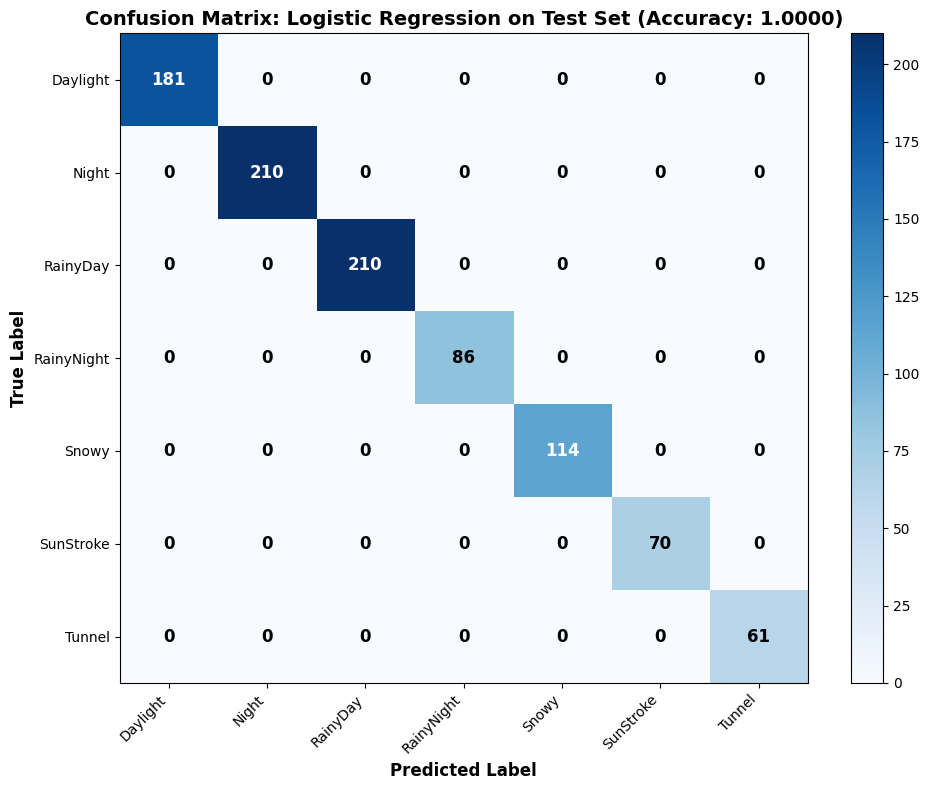


✓ Confusion matrix visualization complete!


In [15]:
# Step 8: Detailed confusion matrix analysis
print("\n" + "="*80)
print("STEP 7: CONFUSION MATRIX ANALYSIS")
print("="*80)

print(f"\n🔍 Analyzing {best_clf_name} performance on test set...")

# Get confusion matrix
y_pred_best = results[best_clf_name]['test_predictions']
cm = confusion_matrix(y_test_raw, y_pred_best)

print(f"\n📈 Confusion Matrix for {best_clf_name}:")
print(f"\n     Predicted Class")
print(f"     " + "  ".join([f"{c:>8}" for c in road_classes]))

for i, class_name in enumerate(road_classes):
    print(f"{class_name:>5} {' '.join([f'{cm[i,j]:>8}' for j in range(len(road_classes))])}")

# Calculate per-class metrics
print(f"\n📊 PER-CLASS PERFORMANCE METRICS:")
print(f"\n{'Class':<20} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print("-" * 68)

precision, recall, f1, support = precision_recall_fscore_support(y_test_raw, y_pred_best, average=None)

for i, class_name in enumerate(road_classes):
    # Calculate per-class accuracy
    tp = cm[i, i]
    total = np.sum(cm[i, :])
    class_accuracy = tp / total if total > 0 else 0
    
    print(f"{class_name:<20} {class_accuracy:<12.4f} {precision[i]:<12.4f} {recall[i]:<12.4f} {f1[i]:<12.4f}")

# Visualize confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(cm, cmap='Blues', aspect='auto')

# Set ticks and labels
ax.set_xticks(range(len(road_classes)))
ax.set_yticks(range(len(road_classes)))
ax.set_xticklabels(road_classes, rotation=45, ha='right')
ax.set_yticklabels(road_classes)

ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
ax.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax.set_title(f'Confusion Matrix: {best_clf_name} on Test Set (Accuracy: {test_accuracy:.4f})', fontsize=14, fontweight='bold')

# Add text annotations
for i in range(len(road_classes)):
    for j in range(len(road_classes)):
        text = ax.text(j, i, cm[i, j], ha="center", va="center", 
                      color="white" if cm[i, j] > cm.max() / 2 else "black", 
                      fontsize=12, fontweight='bold')

fig.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

print(f"\n✓ Confusion matrix visualization complete!")



STEP 8: ROC-AUC ANALYSIS

📊 Computing ROC curves for each road class (One-vs-Rest approach)...


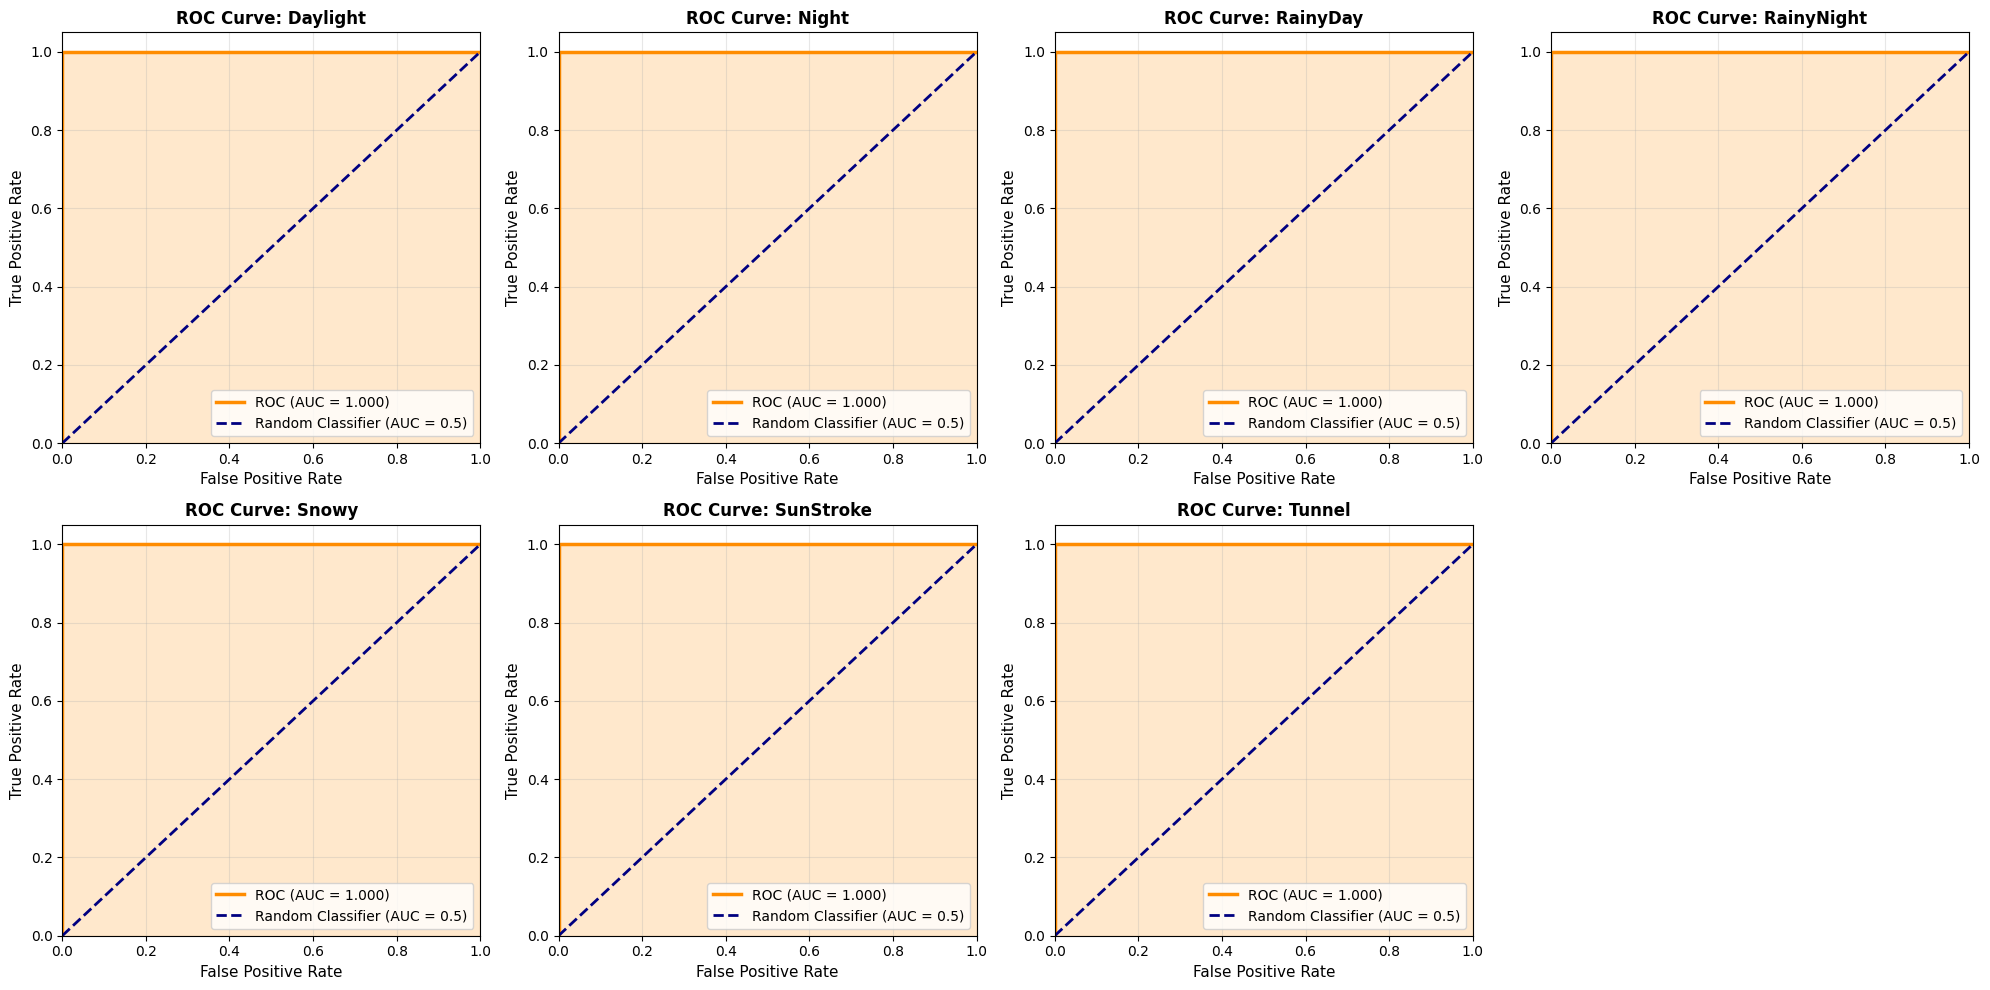


📈 ROC-AUC SCORES:

Class                AUC Score       Interpretation                          
---------------------------------------------------------------------------
Daylight             1.0000          Excellent discrimination 🌟              
Night                1.0000          Excellent discrimination 🌟              
RainyDay             1.0000          Excellent discrimination 🌟              
RainyNight           1.0000          Excellent discrimination 🌟              
Snowy                1.0000          Excellent discrimination 🌟              
SunStroke            1.0000          Excellent discrimination 🌟              
Tunnel               1.0000          Excellent discrimination 🌟              
---------------------------------------------------------------------------
Macro-average        1.0000         
Weighted-average     1.0000         

✓ ROC-AUC analysis complete!


In [16]:
# Step 9: ROC-AUC Analysis
print("\n" + "="*80)
print("STEP 8: ROC-AUC ANALYSIS")
print("="*80)

print(f"\n📊 Computing ROC curves for each road class (One-vs-Rest approach)...")

# Binarize labels for multi-class ROC
y_test_bin = label_binarize(y_test_raw, classes=range(len(road_classes)))
y_pred_proba = best_clf.predict_proba(x_test_raw)

# Plot ROC curves
n_classes = len(road_classes)
if n_classes == 2:
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    axes = [ax]
else:
    fig, axes = plt.subplots(2, (n_classes + 1) // 2, figsize=(5 * ((n_classes + 1) // 2), 10))
    axes = axes.flatten()

auc_scores = {}

for i, class_name in enumerate(road_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    auc_scores[class_name] = roc_auc
    
    ax = axes[i]
    ax.plot(fpr, tpr, color='darkorange', lw=2.5, label=f'ROC (AUC = {roc_auc:.3f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier (AUC = 0.5)')
    ax.fill_between(fpr, tpr, alpha=0.2, color='darkorange')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=11)
    ax.set_ylabel('True Positive Rate', fontsize=11)
    ax.set_title(f'ROC Curve: {class_name}', fontsize=12, fontweight='bold')
    ax.legend(loc="lower right")
    ax.grid(alpha=0.3)

# Hide extra subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

# Calculate macro and weighted AUC
roc_auc_macro = roc_auc_score(y_test_bin, y_pred_proba, multi_class='ovr', average='macro')
roc_auc_weighted = roc_auc_score(y_test_bin, y_pred_proba, multi_class='ovr', average='weighted')

print(f"\n📈 ROC-AUC SCORES:")
print(f"\n{'Class':<20} {'AUC Score':<15} {'Interpretation':<40}")
print("-" * 75)

for class_name, auc_score in auc_scores.items():
    if auc_score >= 0.9:
        interpretation = "Excellent discrimination 🌟"
    elif auc_score >= 0.8:
        interpretation = "Good discrimination ✓"
    elif auc_score >= 0.7:
        interpretation = "Fair discrimination ⚠"
    else:
        interpretation = "Poor discrimination ❌"
    
    print(f"{class_name:<20} {auc_score:<15.4f} {interpretation:<40}")

print("-" * 75)
print(f"{'Macro-average':<20} {roc_auc_macro:<15.4f}")
print(f"{'Weighted-average':<20} {roc_auc_weighted:<15.4f}")

print(f"\n✓ ROC-AUC analysis complete!")



STEP 9: LEARNING CURVES & OVERFITTING DETECTION

📚 Generating learning curves for Logistic Regression...
   This shows how performance changes with increasing training data.
   • Large gap = Overfitting (model memorizes data)
   • Small gap = Good generalization
[learning_curve] Training set sizes: [ 248  496  744  992 1241 1489 1737 1985 2233 2482]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    3.7s finished
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    3.7s finished


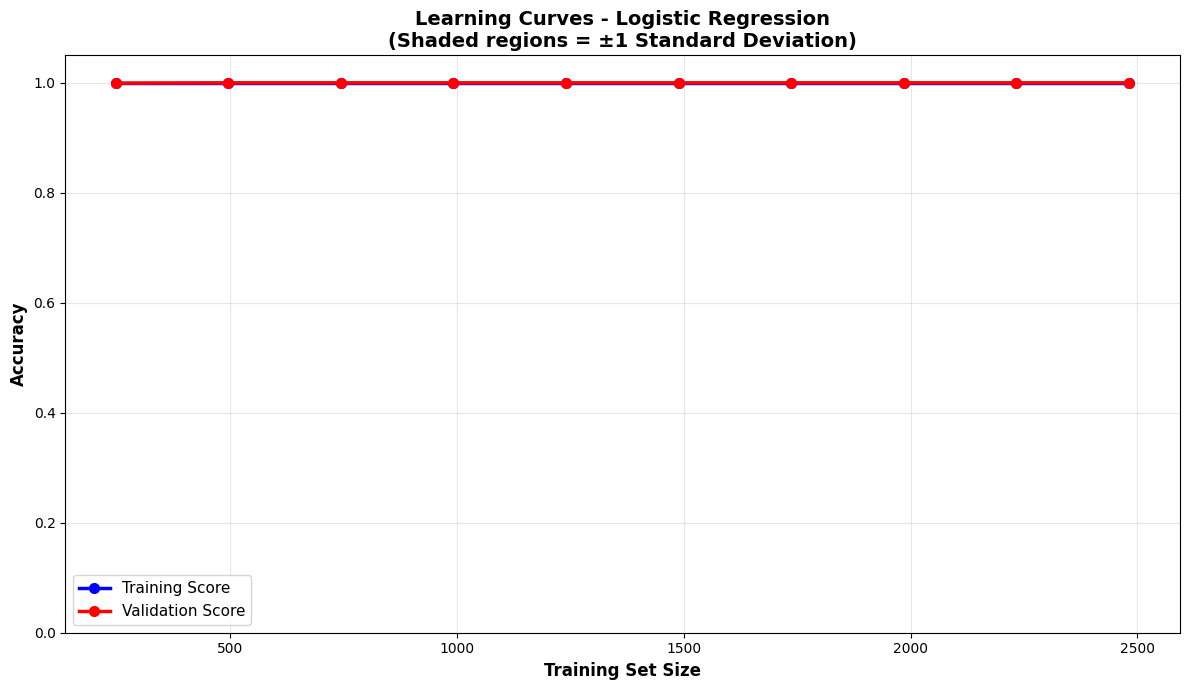


📊 LEARNING CURVE ANALYSIS:
   • Final Training Score: 1.0000
   • Final Validation Score: 1.0000
   • Train-Validation Gap: 0.0000

✓ GOOD GENERALIZATION!
   The model generalizes well to unseen data.


In [17]:
# Step 10: Learning curves to detect overfitting
print("\n" + "="*80)
print("STEP 9: LEARNING CURVES & OVERFITTING DETECTION")
print("="*80)

print(f"\n📚 Generating learning curves for {best_clf_name}...")
print(f"   This shows how performance changes with increasing training data.")
print(f"   • Large gap = Overfitting (model memorizes data)")
print(f"   • Small gap = Good generalization")

# Generate learning curve
train_sizes, train_scores, val_scores = learning_curve(
    best_clf, 
    x_train_raw, y_train_raw,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    verbose=1
)

# Calculate statistics
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot learning curves
fig, ax = plt.subplots(figsize=(12, 7))

ax.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Score', linewidth=2.5, markersize=7)
ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15, color='blue')

ax.plot(train_sizes, val_mean, 'o-', color='red', label='Validation Score', linewidth=2.5, markersize=7)
ax.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.15, color='red')

ax.set_xlabel('Training Set Size', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_title(f'Learning Curves - {best_clf_name}\n(Shaded regions = ±1 Standard Deviation)', 
             fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=11)
ax.grid(alpha=0.3)
ax.set_ylim([0, 1.05])

plt.tight_layout()
plt.show()

# Analyze overfitting
gap = train_mean[-1] - val_mean[-1]

print(f"\n📊 LEARNING CURVE ANALYSIS:")
print(f"   • Final Training Score: {train_mean[-1]:.4f}")
print(f"   • Final Validation Score: {val_mean[-1]:.4f}")
print(f"   • Train-Validation Gap: {gap:.4f}")

if gap > 0.1:
    print(f"\n⚠️  HIGH OVERFITTING DETECTED!")
    print(f"   The model is memorizing the training data.")
    print(f"   Suggestions:")
    print(f"   - Add more training data")
    print(f"   - Use regularization (increase C parameter)")
    print(f"   - Simplify model (reduce max_depth, increase dropout)")
elif gap > 0.05:
    print(f"\n⚠️  MODERATE OVERFITTING")
    print(f"   Consider fine-tuning regularization parameters.")
else:
    print(f"\n✓ GOOD GENERALIZATION!")
    print(f"   The model generalizes well to unseen data.")

# Additional insights
if val_mean[-1] < 0.7:
    print(f"\n📌 Model accuracy is relatively low ({val_mean[-1]:.4f})")
    print(f"   Suggestions to improve:")
    print(f"   - Use more sophisticated features")
    print(f"   - Try different classifiers")
    print(f"   - Increase model complexity (for underfitting)")


In [18]:
# Step 11: Final summary and recommendations
print("\n" + "="*80)
print("STEP 10: FINAL SUMMARY & RECOMMENDATIONS")
print("="*80)

print(f"\n🎯 CLASSIFICATION PERFORMANCE SUMMARY")
print(f"\n{'Metric':<30} {'Value':<20} {'Interpretation':<40}")
print("-" * 90)

print(f"{'Best Classifier':<30} {best_clf_name:<20} {'Top performing model':<40}")
print(f"{'Test Accuracy':<30} {test_accuracy:.4f:<20} {f'{test_accuracy*100:.1f}% correct predictions':<40}")
print(f"{'Cross-Val Accuracy':<30} {results[best_clf_name]['cv_accuracy']:.4f:<20} {'Estimated real-world performance':<40}")
print(f"{'Macro-average AUC':<30} {roc_auc_macro:.4f:<20} {'Average AUC across all classes':<40}")
print(f"{'Train-Val Gap':<30} {gap:.4f:<20} {'Overfitting indicator (lower is better)':<40}")

print(f"\n📊 CLASS-WISE PERFORMANCE")
print(f"\nTop Performing Classes:")
for i, class_name in enumerate(road_classes):
    if recall[i] >= 0.9:
        print(f"   ✓ {class_name}: {recall[i]:.4f} recall")

print(f"\nClasses Needing Improvement:")
for i, class_name in enumerate(road_classes):
    if recall[i] < 0.8:
        print(f"   ⚠ {class_name}: {recall[i]:.4f} recall")

print(f"\n💡 RECOMMENDATIONS FOR IMPROVEMENT")
print(f"\n1. DATA AUGMENTATION")
print(f"   • Add image transformations (rotation, brightness, contrast)")
print(f"   • Collect more samples, especially for underperforming classes")

print(f"\n2. MODEL ENHANCEMENT")
print(f"   • Try ensemble methods (Gradient Boosting, XGBoost)")
print(f"   • Use different feature extractors (DenseNet, EfficientNet)")
print(f"   • Fine-tune ResNet50 end-to-end instead of just using features")

print(f"\n3. HYPERPARAMETER TUNING")
print(f"   • Grid search for optimal parameters")
print(f"   • Test different kernel functions for SVM")
print(f"   • Adjust tree depths and regularization")

print(f"\n4. CROSS-VALIDATION STRATEGY")
print(f"   • Increase to 10-fold CV for more robust estimates")
print(f"   • Use time-series CV if temporal patterns exist")

print(f"\n✓ ANALYSIS COMPLETE!")
print(f"\n📁 Saved artifacts:")
print(f"   • Model: roads_best_model.joblib")
print(f"   • Visualizations: Confusion Matrix, ROC Curves, Learning Curves")



STEP 10: FINAL SUMMARY & RECOMMENDATIONS

🎯 CLASSIFICATION PERFORMANCE SUMMARY

Metric                         Value                Interpretation                          
------------------------------------------------------------------------------------------
Best Classifier                Logistic Regression  Top performing model                    


ValueError: Invalid format specifier '.4f:<20' for object of type 'float'